In [1]:
#Import packages
import numpy as np
from keras.layers import *
from keras.models import *
from keras.datasets import mnist
from keras.optimizers import RMSprop
import keras.backend as K
import matplotlib.pyplot as plt
from functools import partial
import glob
import os
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Set the path to the directory containing the array files
dir_path = "C:\\NetHack\\sys\\windows\\vs\\NetHackW\\levels"

x_train = []

# Set the number of rows and columns for the array
rows = 21
cols = 80

# Get a list of all files in the directory with the .bin extension
file_list = glob.glob(os.path.join(dir_path, "level_data_*.bin"))

# Loop through the file list and save each plot image as a PNG file
for file_path in file_list:
    # Read the array from the file
    arr = np.fromfile(file_path, dtype=np.uint8).reshape((rows, cols))

    # Determine the longest dimension of the rectangular image
    max_dim = 80

    # Pad the array to make it square using the last value of the array
    pad_width = ((0, max_dim - arr.shape[0]), (0, max_dim - arr.shape[1]))
    arr_padded = np.pad(arr, pad_width=pad_width, mode='constant', constant_values=arr[-1,-1])
    x_train.append(arr_padded)
    
x_train = np.array(x_train).astype('float32')

# Normalize the pixel values to the range [0, 1]
x_train /= 255.0

# Add a new dimension with size 1 at the end of x_train
x_train = np.expand_dims(x_train, axis=-1)


print(np.shape(x_train))

(10000, 80, 80, 1)


In [3]:
def gradient_penalty_loss(y_true, y_pred, sample, weight, sample_weight=None):
    gradients = K.gradients(y_pred, sample)[0]
    gradients_sqr = K.square(gradients)
    gradient_penalty = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))

    # (weight / 2) * ||grad||^2
    # Penalize the gradient norm
    return K.mean(gradient_penalty) * (weight / 2)

In [4]:
from tensorflow import keras
from keras.models import load_model

# Load the saved generator and discriminator models
generator = load_model('AdaIN 80x80 Models\\generator_model_25000.h5')
discriminator = load_model('AdaIN 80x80 Models\\discriminator_model_25000.h5')

#Build network to train the discriminator.
#Discriminator will train, but Generator won't train.
for layer in discriminator.layers:
    layer.trainable = True
    
for layer in generator.layers:
    layer.trainable = False
    
#Get real image
real_image = Input([80, 80, 1])
#Discriminator classifies
validity_real = discriminator(real_image)


#Get latent input
latent_input = Input([100])

#Generate an image
fake_image = generator(latent_input)

#Discriminator classifies
validity_fake = discriminator(fake_image)

#Create and compile the model
DiscriminatorModel = Model(inputs = [real_image, latent_input], outputs = [validity_real, validity_fake, validity_real])

gp_loss_partial = partial(gradient_penalty_loss, sample = real_image, weight = 10)

DiscriminatorModel.compile(optimizer = RMSprop(lr = 0.0002), loss = ['mean_squared_error', 'mean_squared_error', gp_loss_partial])

DiscriminatorModel.summary()

C:\Users\basak\anaconda3\envs\gputest\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 80, 80, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 80, 80, 1)    14373569    input_2[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1)            1337273     input_1[0][0]                    
                                                                 model_1[1][0]              

In [5]:
#Build network to train the generator.
#Discriminator won't train, but Generator will train.
for layer in discriminator.layers:
    layer.trainable = False
    
for layer in generator.layers:
    layer.trainable = True

#Get latent input
latent_input = Input([100])

#Generate an image
fake_image = generator(latent_input)

#Discriminator classifies
validity = discriminator(fake_image)

#Create and compile the model
GeneratorModel = Model(inputs = latent_input, outputs = validity)

GeneratorModel.compile(optimizer = RMSprop(lr = 0.0002), loss = 'mean_squared_error')

GeneratorModel.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 80, 80, 1)         14373569  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1337273   
Total params: 15,710,842
Trainable params: 14,373,569
Non-trainable params: 1,337,273
_________________________________________________________________


In [6]:
#Hyperparameters
batch_size = 64
iterations = 25000

#Loss tracking
d_loss = []
g_loss = []
gp_loss = []
#Train the models in a loop
for i in range(iterations):
    
    print('\rIteration ' + str(i), end = '\r')
    
    #Get labels
    real_labels = np.ones([batch_size, 1])
    fake_labels = np.zeros([batch_size, 1])
    
    #Get images and latent vectors
    image_indices = np.random.randint(0, x_train.shape[0] - 1, [batch_size])
    real_images = x_train[image_indices]
    latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 100])
    #latent_vectors = np.random.randint(2,[batch_size, 8])
    
    #Train D
    loss = DiscriminatorModel.train_on_batch([real_images, latent_vectors], [real_labels, fake_labels, real_labels])
    d_loss.append(loss[1]/2 + loss[2]/2)
    gp_loss.append(loss[3])
    
    #Get latent vectors
    latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 100])
    
    #Train G
    loss = GeneratorModel.train_on_batch(latent_vectors, real_labels)
    g_loss.append(loss)

C:\Users\basak\anaconda3\envs\gputest\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


C:\Users\basak\anaconda3\envs\gputest\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


C:\Users\basak\anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


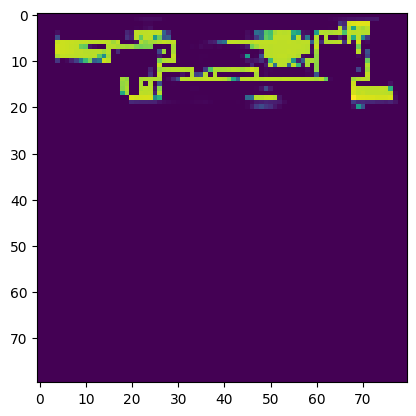

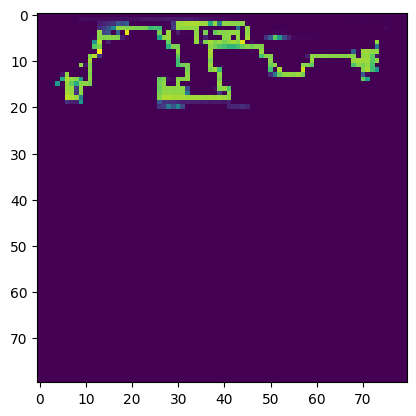

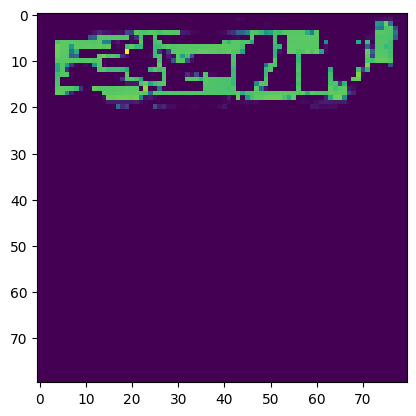

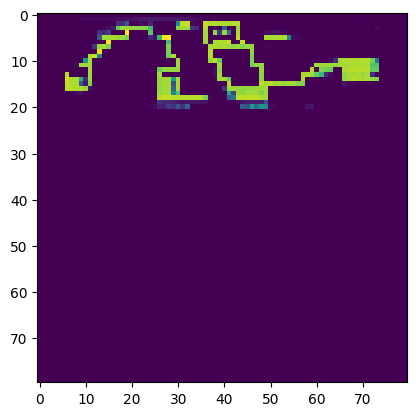

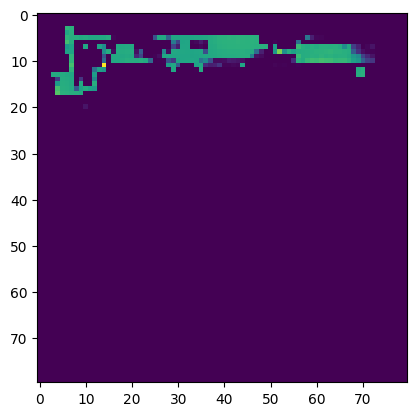

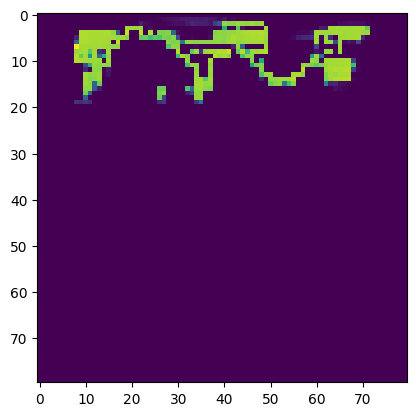

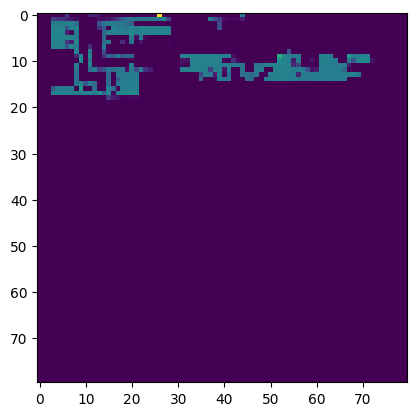

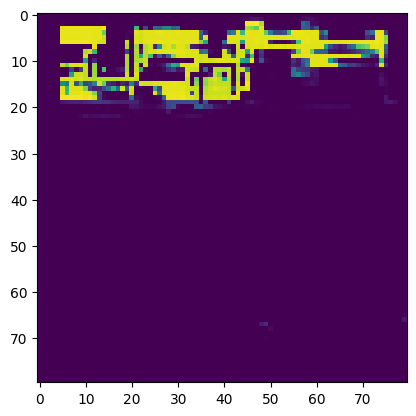

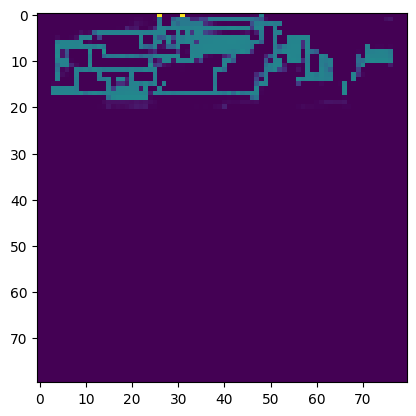

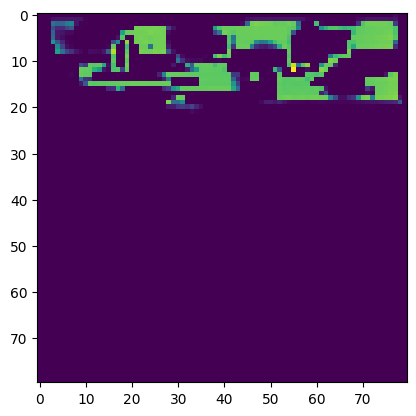

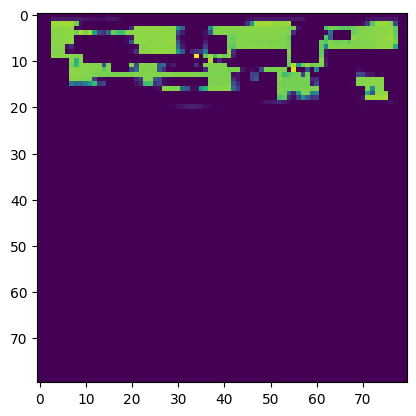

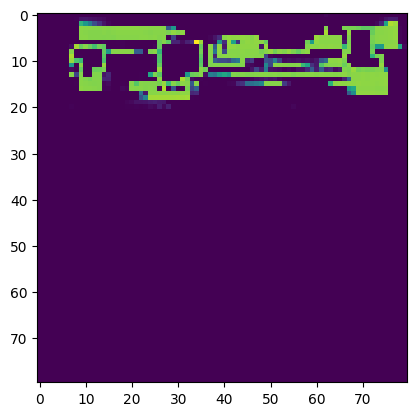

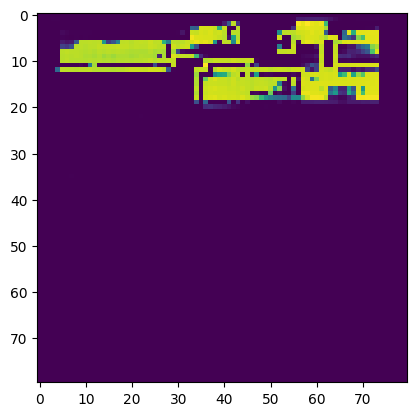

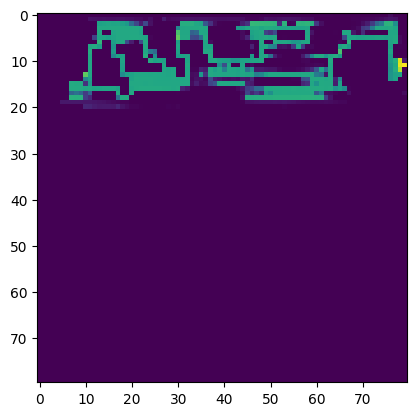

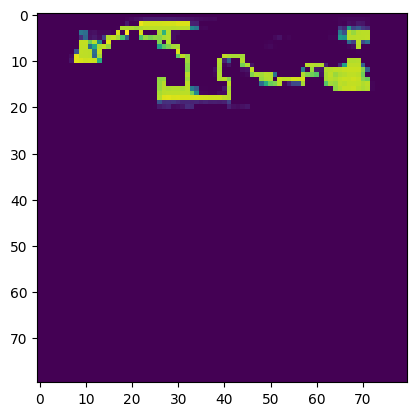

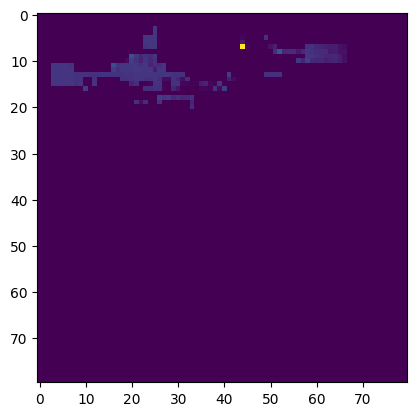

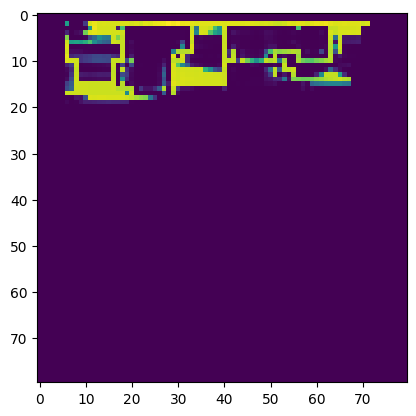

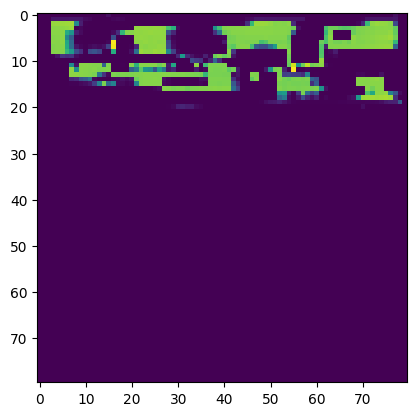

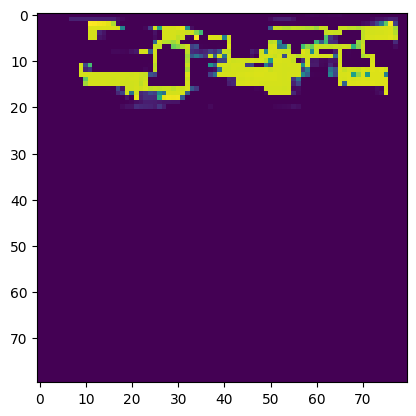

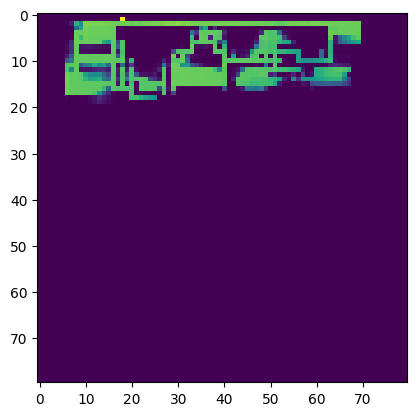

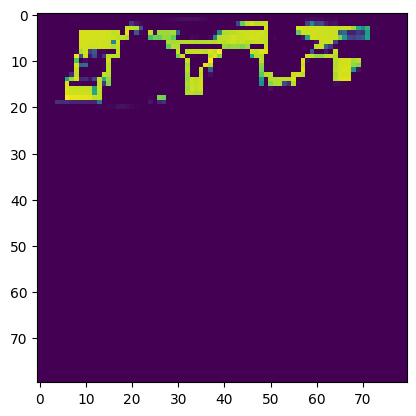

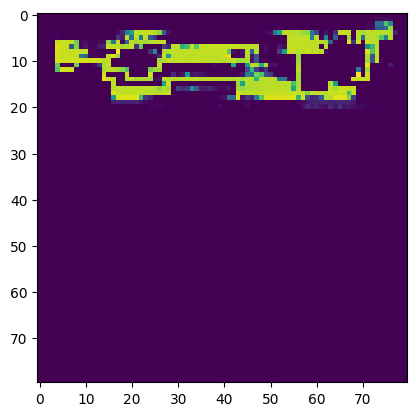

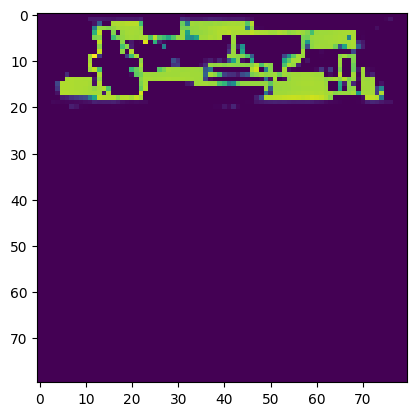

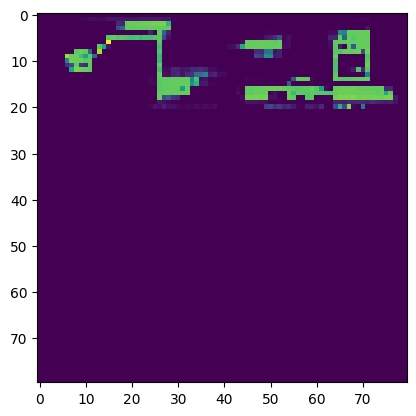

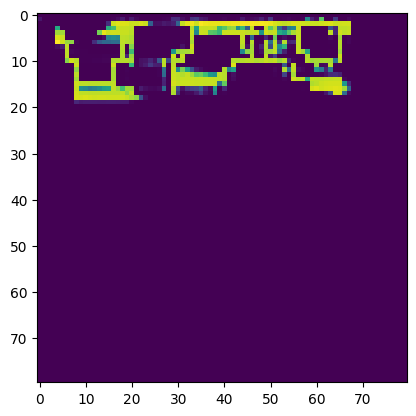

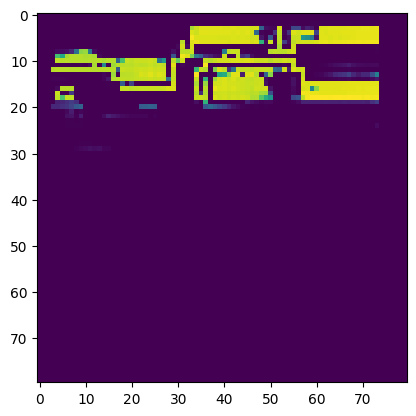

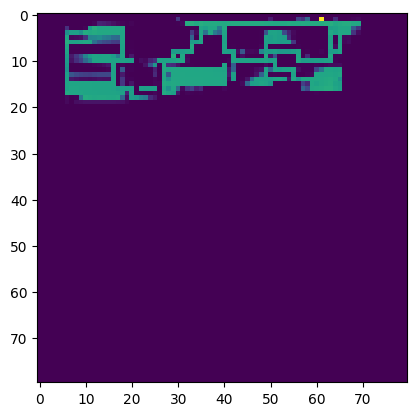

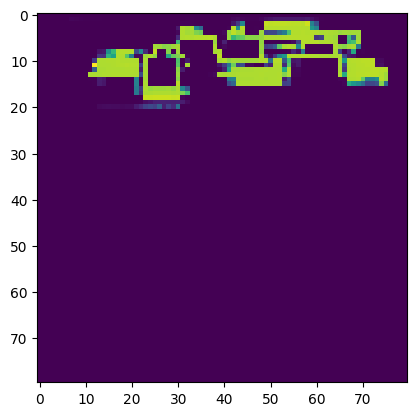

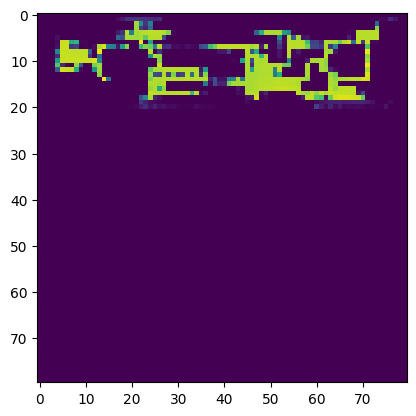

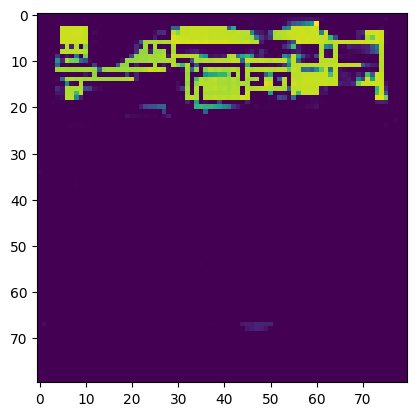

In [7]:
#Show samples
latent_vectors = np.random.normal(0.0, 1.0, [64, 100])
fake_images = generator.predict(latent_vectors)

for i in range(10, 40):
    plt.figure(i)
    plt.imshow(fake_images[i].reshape([80, 80]))

plt.show()

In [10]:
# Save the generator model
generator.save('AdaIN 80x80 Models\\generator_model_50000.h5')

# Save the discriminator model
discriminator.save('AdaIN 80x80 Models\\discriminator_model_50000.h5')

In [11]:

# Load the saved generator and discriminator models
generator = load_model('AdaIN 80x80 Models\\generator_model_50000.h5')
discriminator = load_model('AdaIN 80x80 Models\\discriminator_model_50000.h5')


C:\Users\basak\anaconda3\envs\gputest\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [12]:
latent_vectors = np.random.normal(0.0, 1.0, [64, 100])
fake_images = generator.predict(latent_vectors)


C:\Users\basak\anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


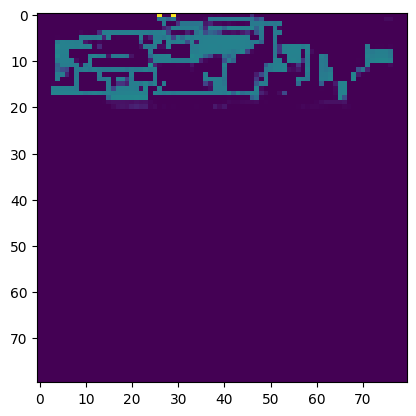

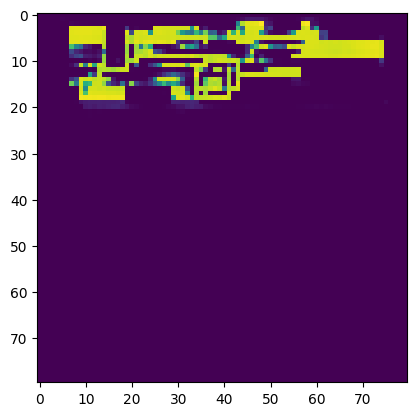

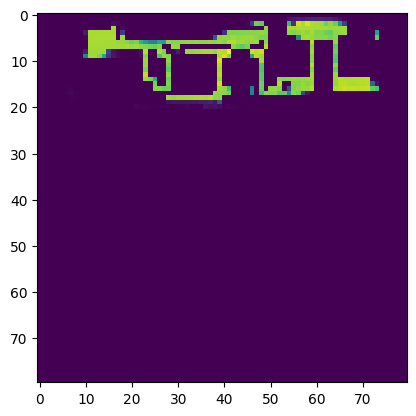

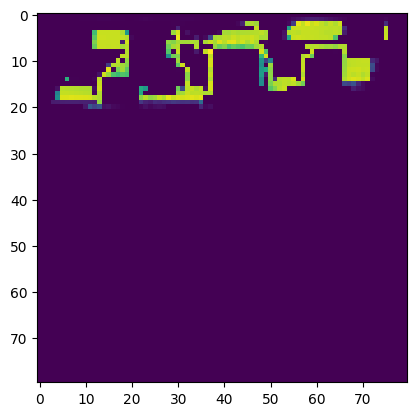

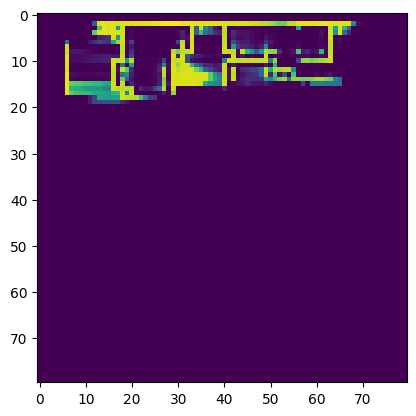

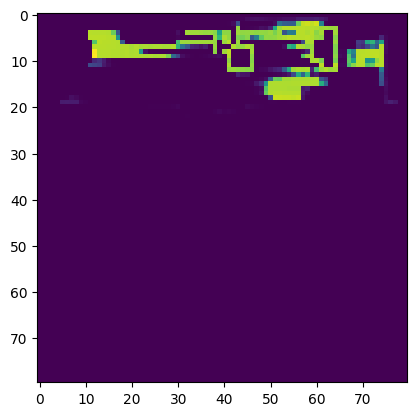

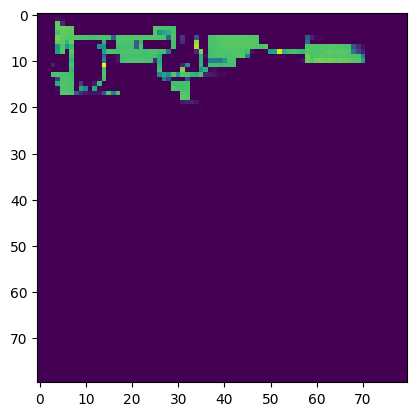

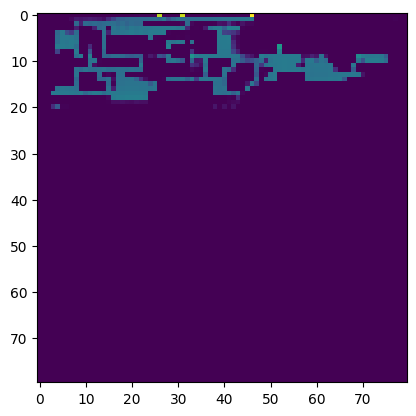

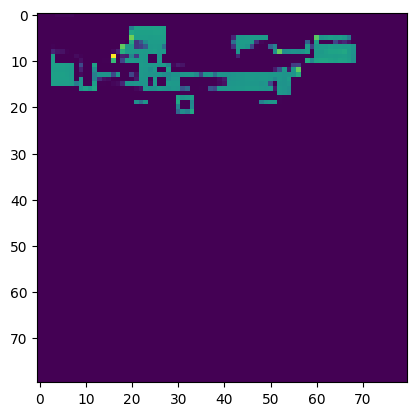

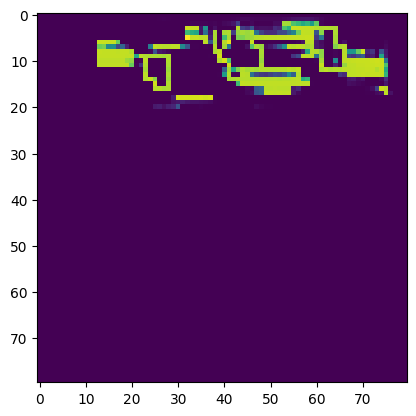

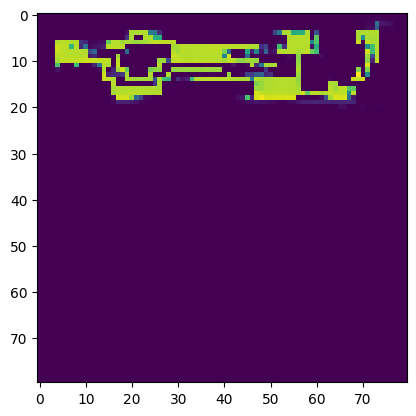

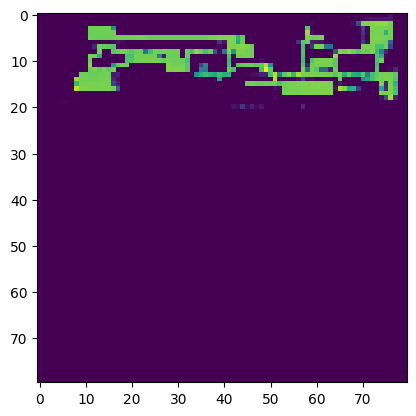

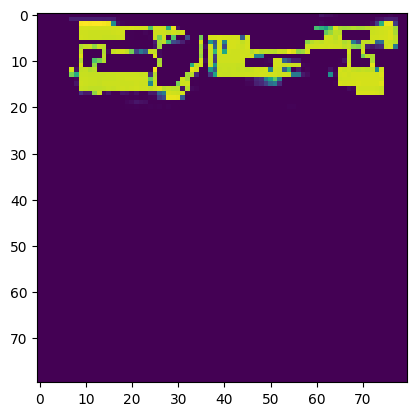

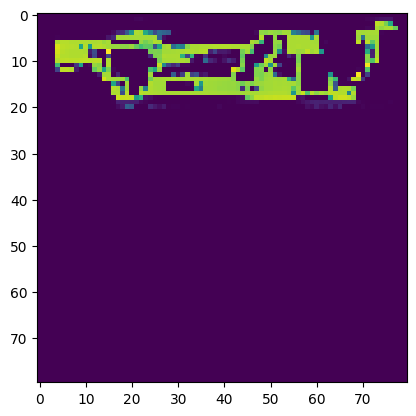

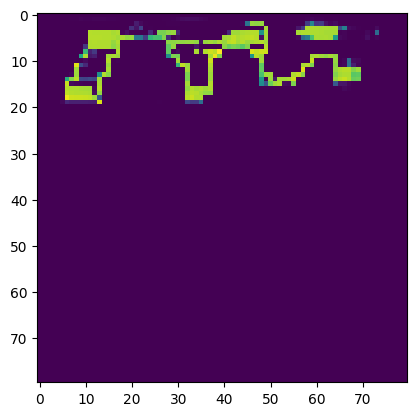

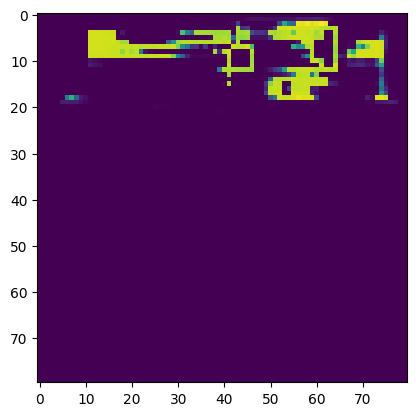

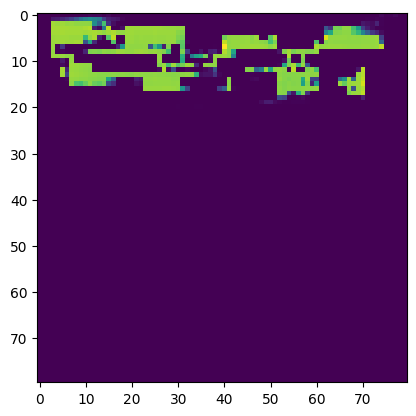

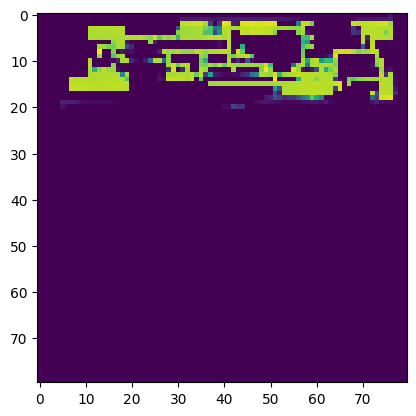

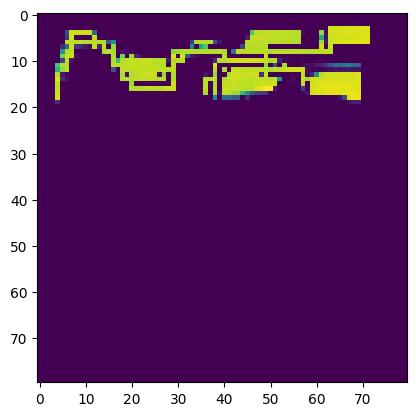

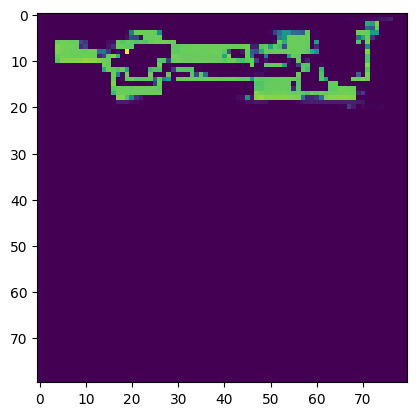

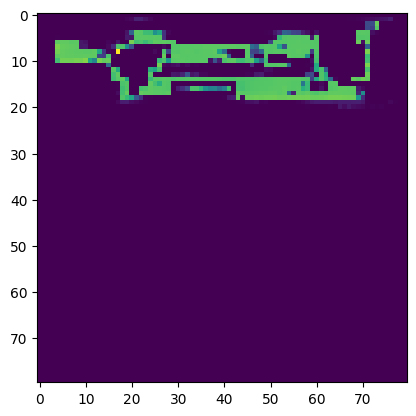

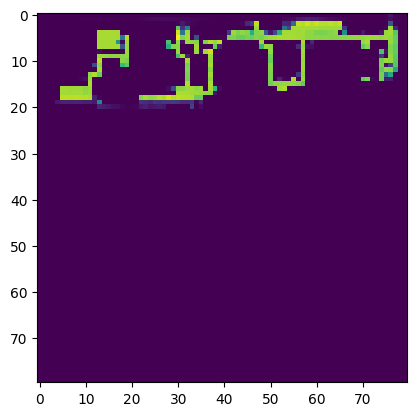

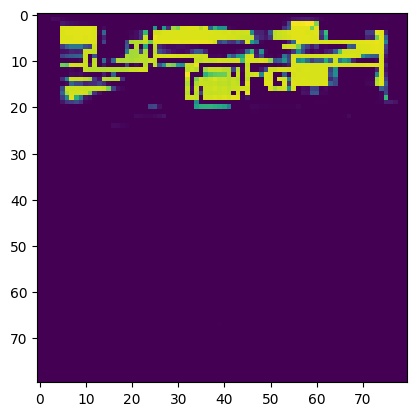

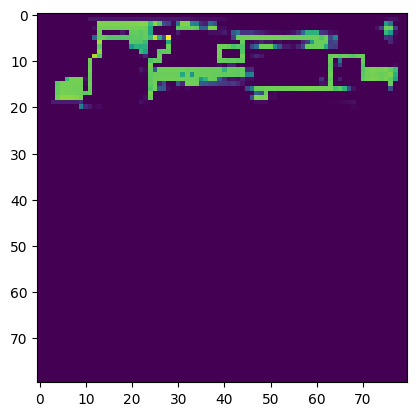

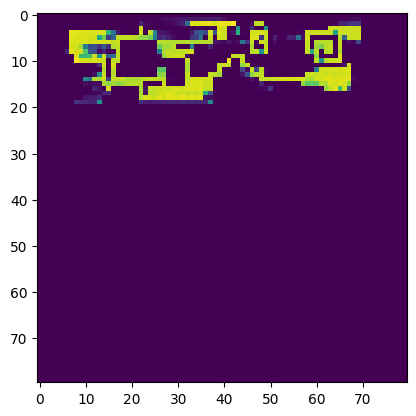

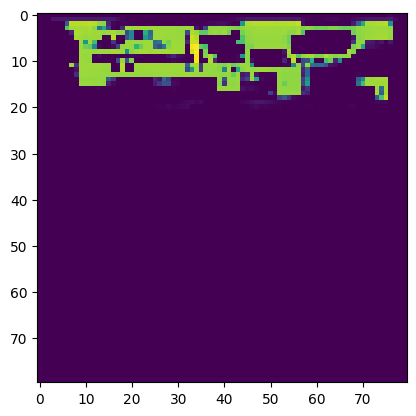

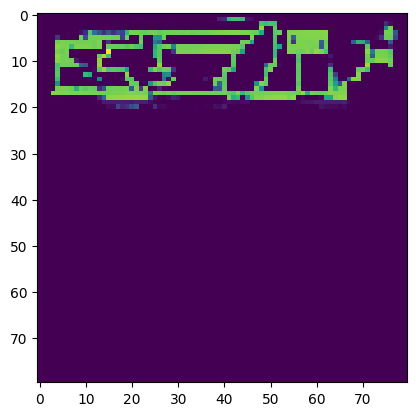

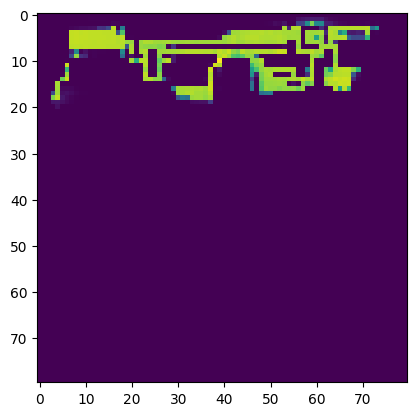

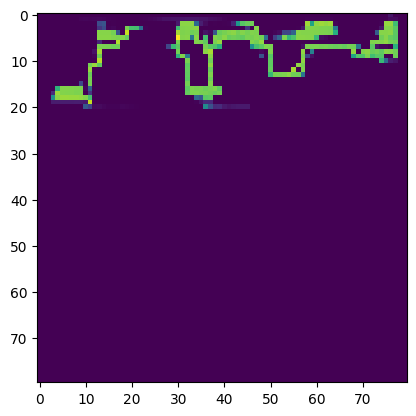

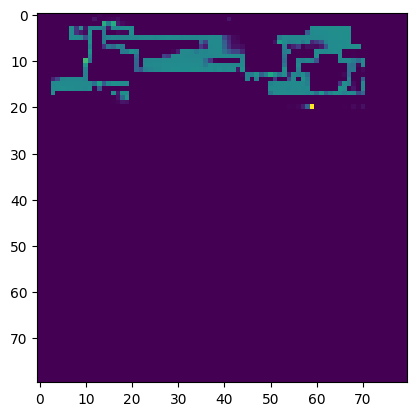

In [13]:
for i in range(10, 40):
    plt.figure(i)
    plt.imshow(fake_images[i].reshape([80, 80]))

plt.show()

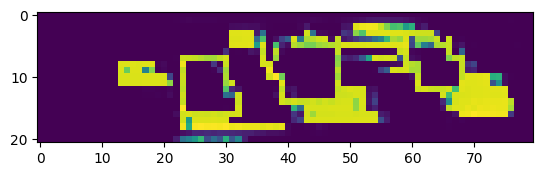

In [16]:
a = fake_images[0][:, :, 0]
reshaped = a[:21, :80]
plt.imshow(reshaped)

with open('output.bin', 'wb') as f:
    reshaped.tofile(f)